In [2]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import shap
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# from typen import enforce_type_hints

%load_ext autoreload
%autoreload 2

from scripts import *
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%store -r df_merged
df_merged

,T,T_a,DD,Ff,N,Nh,Cl,Po,U,Ch,...,RRR,DD_,diff,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3
2012-11-01 00:00:00,-1.9,-6.0,"Ветер, дующий с северо-запада",3.0,0.0,NaN,NaN,763.7,75.0,NaN,...,NaN,North,4.1,4.1,-4.8,-4.0,-4.0,-4.266667,2.366667,2.366667
2012-11-01 03:00:00,-3.7,-7.0,"Ветер, дующий с северо-запада",2.0,10.0,10.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",764.9,83.0,"Перистых, перисто-кучевых или перисто-слоистых...",...,NaN,North,3.3,3.3,-5.4,-5.8,-4.7,-5.300000,1.600000,1.600000
2012-11-01 06:00:00,-5.1,-7.0,"Ветер, дующий с северо-запада",1.0,100.0,0.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",766.4,90.0,"Перистые нитевидные, иногда когтевидные, не ра...",...,NaN,North,1.9,1.9,-6.9,-6.4,-7.5,-6.933333,1.833333,1.833333
2012-11-01 09:00:00,-6.6,-8.0,"Ветер, дующий с северо-северо-запада",1.0,0.0,NaN,NaN,767.6,94.0,NaN,...,Осадков нет,North,1.4,1.4,-6.9,-7.6,-8.1,-7.533333,0.933333,0.933333
2012-11-01 12:00:00,0.9,0.0,"Ветер, дующий с юго-запада",1.0,100.0,0.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",768.6,64.0,"Перисто-кучевые одни или перисто-кучевые, сопр...",...,NaN,West,0.9,0.9,0.0,-0.4,0.0,-0.133333,1.033333,1.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 09:00:00,-25.8,-24.0,"Ветер, дующий с востока",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",755.8,79.0,NaN,...,Следы осадков,East,-1.8,1.8,-26.5,-22.8,-27.2,-25.500000,-0.300000,0.300000
2021-02-28 12:00:00,-20.7,-20.0,"Ветер, дующий с востока",4.0,100.0,0.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",753.9,81.0,Перистые (часто в виде полос) и перисто-слоист...,...,NaN,East,-0.7,0.7,-20.9,-20.4,-21.1,-20.800000,0.100000,0.100000
2021-02-28 15:00:00,-17.2,-17.0,"Ветер, дующий с востока",5.0,100.0,40.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",751.9,80.0,Перистые (часто в виде полос) и перисто-слоист...,...,NaN,East,-0.2,0.2,-17.3,-16.4,-16.4,-16.700000,-0.500000,0.500000
2021-02-28 18:00:00,-17.3,-17.0,"Ветер, дующий с востока",6.0,100.0,100.0,Кучево-дождевые волокнистые (часто с наковальн...,750.1,82.0,NaN,...,NaN,East,-0.3,0.3,-17.6,-16.0,-16.9,-16.833333,-0.466667,0.466667


In [ ]:
#download html class
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

class Downloader():
    def __init__(self,start_year, end_year, station_id, db_name='weather.db'):
        self.start_year = start_year
        self.end_year = end_year
        self.station_id = station_id
        self.db_name = db_name
    def download(self, save_in_db=True):
        start_year = self.start_year
        end_year = self.end_year
        station_id = self.station_id
        
        m_df = pd.DataFrame()
        
        for year in range(start_year, end_year + 1):
            for month in range(1, 12 + 1):
                url = f"https://www.ogimet.com/cgi-bin/gsynres?ind={station_id}&lang=en&decoded=yes&ndays=31&ano={year}&mes={month}&day=1"
                soup = BeautifulSoup(requests.get(url).content, "html.parser")
                
                header = [th.get_text(strip=True) for th in soup.thead.select("tr")[0].select("th")]
                
                all_data = []
                for row in soup.thead.select("tr")[1:]:
                    tds = [td.get_text(strip=True) for td in row.select("td")[:-3]]
                    tds.insert(0, tds.pop(0) + " " + tds.pop(0))

                    for td in row.select("td")[-3:]:
                        img = td.select_one("img[onmouseover]")
                        if img:
                            tds.append(re.search(r"'([^']+)'", img["onmouseover"]).group(1))
                        else:
                            tds.append("-")

                    all_data.append(tds)

                df = pd.DataFrame(all_data, columns=header)
#                 print(df)
#                 df.to_csv(f"{year}_{month}.csv", index=False)
                df = df.reindex(index=df.index[::-1])
                m_df = m_df.append(df)
        m_df.to_csv(f'weather_data_{station_id}')
        if save_in_db:
            conn = sql.connect(db_name) # подключение к БД
            m_df.to_sql(f'weather_data_{station_id}', conn)
            
        return m_df
    
    @staticmethod
    def save_to_db(filename, table_name, db_name):
        conn = sql.connect(db_name)
        data = pd.read_csv(filename, skiprows=6, sep=';', index_col=0)
        data.index = pd.to_datetime(data.index, dayfirst=True)
        data.to_sql(filename, table_name, conn)

In [ ]:
# prepare data class
class PreProcessData():
    def __init__(self, data):
        self.m_df = data
    def clean_om(self):
        m_df = self.m_df
        # drop dublicates
        m_df = m_df.loc[~m_df.index.duplicated(keep='first')]

        # replace '-----' to nan
        m_df['T(C)'].replace('-----', np.nan, inplace=True)
        m_df['Td(C)'].replace('-----', np.nan, inplace=True)
        m_df['Tmax(C)'].replace('-----', np.nan, inplace=True)
        m_df['Tmin(C)'].replace('-----', np.nan, inplace=True)

        m_df['T(C)'] = m_df['T(C)'].astype(float)
        m_df['Td(C)'] = m_df['Td(C)'].astype(float)
        m_df['Tmax(C)'] = m_df['Tmax(C)'].astype(float)
        m_df['Tmin(C)'] = m_df['Tmin(C)'].astype(float)

        # Clear incorrect
        m_df['T(C)'].replace(-90.4, np.nan, inplace=True)

        # replace NaN to mean of 2 nb
        m_df['T(C)'] = m_df['T(C)'].where(m_df['T(C)'].values == 999, other=(m_df['T(C)'].fillna(method='ffill') + m_df['T(C)'].fillna(method='bfill'))/2)

        m_df = m_df.shift(periods=2)
        m_df = m_df.iloc[2:]

        return m_df

In [ ]:
# Очистка и соединение в один датасет
class MergeData:
    def __init__(self, file_list):
        self.file_list = file_list
        self.df_omsk = None
        self.df_airport = None
        self.df_kal = None
        self.df_sher = None
        self.df_sar = None
        
        self.df_merged = None
        
    def load_merge(save=True):
        u = Utils()
        
        self.df_omsk = pd.read_csv(file_list[0], skiprows=6, sep=';', index_col=0)
        self.df_omsk.index = pd.to_datetime(self.df_omsk.index, dayfirst=True)
        self.df_omsk = u.inp_prep(df_omsk)
        
        self.df_airport = pd.read_csv(file_list[1], skiprows=6, sep=';', index_col=0)
        self.df_airport.index = pd.to_datetime(self.df_airport.index, dayfirst=True)
        self.df_airport = u.inp_prep(self.df_airport, col_drop_list=['Unnamed: 13', "W'W'", 'ff10'])
        
        
        # to one df
        df_airport_ = self.df_airport['2012-11':'2021-02']
        df_omsk_ = self.df_omsk['2012-11':'2021-02']

        df_airport_ = df_airport_[['T', 'DD', 'Ff', 'P0', 'c']]
        df_airport_ = df_airport_.rename(columns={'T':'T_a', 'DD':'DD_a', 'Ff':'Ff_a', 'P0':'P0_a', 'c':'c_a'})

        df_omsk_ = df_omsk_[['T', 'Po', 'DD', 'Ff', 'N', 'Nh', 'Cl', 'U', 'Cm', 'Ch', 'H', 'RRR']] # Nh, количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдающихся облаков Cm

        df_omsk_airport_m = pd.merge(df_airport_, df_omsk_, how='inner', left_index=True, right_index=True)
        
        df_omsk_airport_m1 = df_omsk_airport_m[['T', 'T_a', 'DD', 'Ff', 'N', 'Nh', 'Cl', 'Po', 'U', 'Ch', 'Cm', 'H', 'RRR']]
        df_omsk_airport_m1 = u.conv_wind(df_omsk_airport_m1)
        df_omsk_airport_m1 = u.conv_cloud(df_omsk_airport_m1)
        df_omsk_airport_m1 = u.conv_cloud(df_omsk_airport_m1, col_name='Nh')
        
        df_omsk_airport_winter = u.select_winter_p(df_omsk_airport_m1)
        
        df_omsk_airport_winter['diff'] = df_omsk_airport_winter['T'] - df_omsk_airport_winter['T_a']
        df_omsk_airport_winter['abs_diff'] = abs(df_omsk_airport_winter['T'] - df_omsk_airport_winter['T_a'])
        
        
        # load kal
        df_kal = pd.read_csv(file_list[2], skiprows=6, sep=';', index_col=0)
        df_kal.index = pd.to_datetime(df_kal.index, dayfirst=True)
        df_kal = df_kal[['T']]
        self.df_kal = df_kal.rename(columns={'T':'T_kal'})
        
        # load sherb
        df_sher = pd.read_csv('RP5/28791.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
        df_sher.index = pd.to_datetime(df_sher.index, dayfirst=True)
        df_sher = df_sher[['T']]
        self.df_sher = df_sher.rename(columns={'T':'T_sher'})
        
        # load sar
        df_sar = pd.read_csv('RP5/28598.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=0)
        df_sar.index = pd.to_datetime(df_sar.index, dayfirst=True)
        df_sar = df_sar[['T']]
        self.df_sar = df_sar.rename(columns={'T':'T_sar'})
        
        # # to one df
        df_three = pd.concat([self.df_kal, self.df_sher, self.df_sar], axis=1)

        # select winter periods
        df_three_w = u.select_winter_p(df_three)
        df_three_w['three_mean'] = df_three_w[['T_kal', 'T_sher', 'T_sar']].mean(axis=1, skipna=True)
        
        # add omsk and airport
        df_merged = df_omsk_airport_winter.merge(df_three_w, how = 'inner', left_index=True, right_index=True)

        df_merged['diff_3'] = df_merged['T'] - df_merged['three_mean']
        df_merged['abs_diff_3'] = abs(df_merged['T'] - df_merged['three_mean'])

        df_merged1 = df_merged.drop(columns=['T_kal', 'T_sher', 'T_sar'])
        self.df_merged = df_merged1
        # save a new df
        # df_merged.to_csv('df_merged')
        
    def save_to_db(db_name='weather.db'):
        conn = sql.connect(db_name) # подключение к БД
        self.df_merged.to_sql('df_merged', conn)

In [ ]:
md = MergeData(['RP5/28698.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', 'RP5/UNOO.26.09.2012.04.05.2021.1.0.0.ru.utf8.00000000.csv', 'RP5/28696.01.02.2005.03.05.2021.1.0.0.ru.utf8.00000000.csv', 'RP5/28791.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv', 'RP5/28598.01.02.2005.04.05.2021.1.0.0.ru.utf8.00000000.csv'])
md.load_merge()
md.save_to_db()

In [ ]:
# консольный интерфейс с ключами через argParser
class ConsoleInterface:
    def __init__(self):
        pass
    
    def parse_args(self):
        
        parser = argparse.ArgumentParser(description='Optional app description')
        parser.add_argument('--opt_arg', type=int, help='An optional integer argument')
        args = parser.parse_args()
        print("Argument values:")
        print(args.opt_arg)
        
        #Prediction
#         parser.add_argument('--pred', type=int, help='An optional integer argument')
        parser.add_argument('-p', '--pred', action='store_true')
    
        parser.add_argument('dataset_name', type='str')
    
        parser.add_argument('start_train_period', type='int')
        parser.add_argument('end_train_period', type='int')
        
        parser.add_argument('start_test_period', type='int')
        parser.add_argument('end_test_period', type='int')
        
        #test period
        
        #Aggregate
#         parser.add_argument('--agg', type=int, help='An optional integer argument')
        parser.add_argument('-a', '--agg', action='store_true')
        
        parser.add_argument('--type', type=int) # omsk-airport or omsk - oblast
        parser.add_argument('--min_temp', type='int')
        parser.add_argument('--min_diff', type='int')
        parser.add_argument('--show_d', action='store_true')
        parser.add_argument('--show_fi', action='store_true')
        parser.add_argument('--show_shap', type='int')
        
        #get data from db
        parser.add_argument('--getfdb', type=str, help='get data from db dbname')

In [14]:
class Slicer():
    def __getitem__(self, slice_):
        return slice_

class Prediction:
    cat_cols = None
    test_period = None
    df_merged_w_preds = None
    
    def __init__(self, df,  min_t=-1, train_period=Slicer()['2012':'2019-03'], test_period=Slicer()['2019-11':], drop_cols=['diff','abs_diff','diff_3','abs_diff_3', 'T_a', 'T_kal', 'T_sher', 'T_sar', 'three_mean'], target='diff', cat_cols=['DD','DD_', 'Cl', 'Cm','Ch', 'H', 'RRR']):
        
        self.cat_cols = cat_cols
        self.test_period = test_period
        
        self.df_merged_c = df.copy()  # load data
        self.df_merged_c = self.df_merged_c[self.df_merged_c['abs_diff'] > min_t]
        
        self.df_merged_c['Cl'] = self.df_merged_c['Cl'].fillna(0)
        self.df_merged_c['Ch'] = self.df_merged_c['Ch'].fillna(0)
        self.df_merged_c['Cm'] = self.df_merged_c['Cm'].fillna(0)
        self.df_merged_c['H'] = self.df_merged_c['H'].fillna(0)
        self.df_merged_c['RRR'] = self.df_merged_c['RRR'].fillna(0)
        
        self.train_data = self.df_merged_c[train_period]
        self.train_data = self.train_data.drop(columns=drop_cols)
        self.eval_data = self.df_merged_c[test_period]
        self.eval_data = self.eval_data.drop(columns=drop_cols)
        self.train_labels = self.df_merged_c[train_period][target]
        
    def fit(self):
        self.model = CatBoostRegressor(iterations=1000, # {'depth': 10, 'l2_leaf_reg': 5, 'iterations': 1000, 'learning_rate': 0.3}
                           task_type="GPU",
                           devices='0:1',
                         depth=10,
                         l2_leaf_reg=5,
                         learning_rate=0.3)
        
#         display(self.train_data.info())
        
        self.model.fit(self.train_data,
          self.train_labels,
          verbose=False,
         cat_features=self.cat_cols)
        
    def plot_feature_imp(self):
        plt.bar(self.train_data.columns, self.model.get_feature_importance())
        plt.show()
        
    def plot_shap(self, type):
        shap.initjs()
        shap_values = self.model.get_feature_importance(Pool(train_data, train_labels, cat_features=cat_cols), type='ShapValues')
        shap.summary_plot(shap_values, self.train_data)
        
    def mape_vectorized_v2(self, x):
        a = x['diff']
        b = x['diff_p']
        mask = a != 0
        return (np.fabs((a - b))/a)[mask].mean()

    def mean_absolute_percentage_error(self, x):
        y_true = x['diff']
        y_pred = x['diff_p']
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
    def predict(self, plot_with=False):
        preds = self.model.predict(self.eval_data)
        
        mape_vectorized_v2 = self.mape_vectorized_v2
        mean_absolute_percentage_error = self.mean_absolute_percentage_error
        
        eps = 1e-6
        df_merged_w_preds = self.df_merged_c[self.test_period].copy()
        df_merged_w_preds['diff_p'] = pd.Series(preds, index=df_merged_w_preds.index)
        df_merged_w_preds['error'] = abs(df_merged_w_preds['diff'] - df_merged_w_preds['diff_p'])
        df_merged_w_preds['error rel'] = abs(df_merged_w_preds['error']/df_merged_w_preds['diff'] + 1e-6)
        df_merged_w_preds['error rel lg'] = np.log(abs(df_merged_w_preds['error']/df_merged_w_preds['diff'] + 1e-6)*10 +1)
        df_merged_w_preds['mape'] = df_merged_w_preds.apply(mean_absolute_percentage_error, axis=1)
        
        self.df_merged_w_preds = df_merged_w_preds
        
        display(df_merged_w_preds[['diff', 'diff_p', 'error', 'error rel', 'error rel lg']])
        
        if plot_with:
            plot_data(df_merged_w_preds)
        
    def mean_error(self, t_diff=1):
        display(self.df_merged_w_preds['error'][self.df_merged_w_preds['abs_diff'] > t_diff].mean())
    def mean_diff(self, t_diff=1):
        display(abs(self.df_merged_w_preds['diff'][self.df_merged_w_preds['abs_diff'] > t_diff]).mean())
        
def plot_data(data):
    # bar_plot
    df_merged_w_preds = data.copy()
    df_merged_w_preds = df_merged_w_preds[df_merged_w_preds['abs_diff'] >= 1]
    
#     e1 = df_merged_w_preds['error'][df_merged_w_preds['T'] <-5].mean()
#     ad1 = abs(df_merged_w_preds['diff'][df_merged_w_preds['T'] <-5]).mean()

#     e2 = df_merged_w_preds['error'][df_merged_w_preds['T'] <-15].mean()
#     ad2 = abs(df_merged_w_preds['diff'][df_merged_w_preds['T'] <-15]).mean()

#     e3 = df_merged_w_preds['error'][df_merged_w_preds['T'] <-20].mean()
#     ad3 = abs(df_merged_w_preds['diff'][df_merged_w_preds['T'] <-20]).mean()

#     e4 = df_merged_w_preds['error'][df_merged_w_preds['T'] <-25].mean()
#     ad4 = abs(df_merged_w_preds['diff'][df_merged_w_preds['T'] <-25]).mean()
    
    e1 = df_merged_w_preds['error'][df_merged_w_preds['DD_'] == 'North'].mean()
    ad1 = abs(df_merged_w_preds['diff'][df_merged_w_preds['DD_'] == 'North']).mean()
    ad1_ = df_merged_w_preds['diff'][df_merged_w_preds['DD_'] == 'North'].mean()

    e2 = df_merged_w_preds['error'][df_merged_w_preds['DD_'] =='South'].mean()
    ad2 = abs(df_merged_w_preds['diff'][df_merged_w_preds['DD_'] =='South']).mean()
    ad2_ = df_merged_w_preds['diff'][df_merged_w_preds['DD_'] =='South'].mean()
    

    e3 = df_merged_w_preds['error'][df_merged_w_preds['DD_'] =='East'].mean()
    ad3 = abs(df_merged_w_preds['diff'][df_merged_w_preds['DD_'] =='East']).mean()
    ad3_ = df_merged_w_preds['diff'][df_merged_w_preds['DD_'] =='East'].mean()

    e4 = df_merged_w_preds['error'][df_merged_w_preds['DD_'] =='West'].mean()
    ad4 = abs(df_merged_w_preds['diff'][df_merged_w_preds['DD_'] =='West']).mean()
    ad4_ = df_merged_w_preds['diff'][df_merged_w_preds['DD_'] =='West'].mean()

    data1 = [e1, e2, e3, e4]
    data2 = [ad1, ad2, ad3, ad4]
    data3 = [ad1_, ad2_, ad3_, ad4_]

    labels = ['', 'North', '', 'South','', 'East','', 'West']
    X = np.arange(4)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_xticklabels(labels)
    ax.bar(X + 0.00, data1, color = 'b', width = 0.1)
    ax.bar(X + 0.1, data2, color = 'g', width = 0.1)
    ax.bar(X + 0.2, data3, color = 'r', width = 0.1)
    ax.legend(['error','abs actual diff', 'actual diff'], loc='upper right')

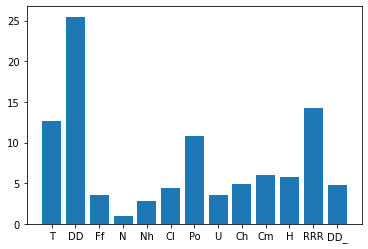

In [15]:
# predict temp. diff:
pred = Prediction(df_merged, 0)
pred.fit()
pred.plot_feature_imp()

,diff,diff_p,error,error rel,error rel lg
2019-11-01 00:00:00,0.1,-0.140992,0.240992,2.409917,3.222835
2019-11-01 03:00:00,-0.4,-0.349605,0.050395,0.125986,0.815301
2019-11-01 06:00:00,0.2,-0.112507,0.312507,1.562537,2.810930
2019-11-01 09:00:00,1.2,-0.068031,1.268031,1.056694,2.448151
2019-11-01 12:00:00,-0.2,-0.208905,0.008905,0.044522,0.368262
...,...,...,...,...,...
2021-02-28 09:00:00,-1.8,-0.666044,1.133956,0.629974,1.987839
2021-02-28 12:00:00,-0.7,-1.618001,0.918001,1.311428,2.647187
2021-02-28 15:00:00,-0.2,-1.313020,1.113020,5.565097,4.036909
2021-02-28 18:00:00,-0.3,-0.249954,0.050046,0.166819,0.981402


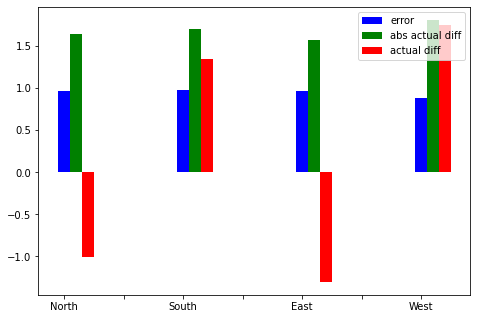

In [16]:
pred.predict(plot_with=True)

In [17]:
pred.mean_error(1)
pred.mean_diff(1)

1.095090797919869

1.8663883089770361

In [18]:
#
class WeatherData:
    conn = None
    weather = None
#     @enforce_type_hints
    def __init__(self, db_name: str) -> pd.core.frame.DataFrame:
        self.conn = sql.connect(db_name)
        
    def select_all(self, table_name: str):
        self.weather = pd.read_sql(f'SELECT * FROM {table_name}', self.conn)
        self.weather['index'] = pd.to_datetime(self.weather['index'], dayfirst=True)
        self.weather.index = self.weather['index']
        self.weather = self.weather.drop(columns=['index'])
        return self.weather
    
    def mean_by(self, month: bool = True, year: bool = False) -> pd.core.frame.DataFrame:
        if self.weather is None:
            raise Exception('You must call select_all for set table name first')
        if month == True:
            return self.weather.groupby(by=self.weather.index.month).mean().head()['T']
        if year == True:
            return self.weather.groupby(by=self.weather.index.year).mean().head()['T']
        
    @staticmethod
    def bar_chart(data: pd.core.frame.DataFrame) -> None:
        display(data.plot(kind='bar'))
        
    @staticmethod    
    def print_head(table: pd.core.frame.DataFrame, count: int = 5) -> None:
        display(table.head(count))

,T,T_a,DD,Ff,N,Nh,Cl,Po,U,Ch,...,RRR,DD_,diff,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3
index,,,,,,,,,,,,,,,,,,,,,
2012-11-01 00:00:00,-1.9,-6.0,"Ветер, дующий с северо-запада",3.0,0.0,NaN,None,763.7,75.0,None,...,None,North,4.1,4.1,-4.8,-4.0,-4.0,-4.266667,2.366667,2.366667
2012-11-01 03:00:00,-3.7,-7.0,"Ветер, дующий с северо-запада",2.0,10.0,10.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",764.9,83.0,"Перистых, перисто-кучевых или перисто-слоистых...",...,None,North,3.3,3.3,-5.4,-5.8,-4.7,-5.300000,1.600000,1.600000


Средняя температура по месяцам:


<AxesSubplot:xlabel='index'>

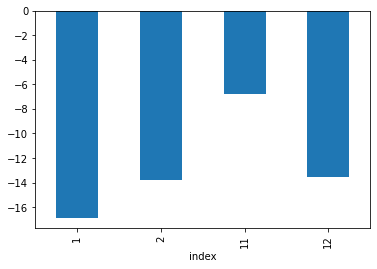

In [19]:
wd = WeatherData('weather.db')
wd.print_head(wd.select_all('df_merged'), 2)
print('Средняя температура по месяцам:')
wd.mean_by()
wd.bar_chart(wd.mean_by())

In [20]:
df_merged.loc['2015-01-05']

,T,T_a,DD,Ff,N,Nh,Cl,Po,U,Ch,...,RRR,DD_,diff,abs_diff,T_kal,T_sher,T_sar,three_mean,diff_3,abs_diff_3
2015-01-05 00:00:00,-5.7,-6.0,"Ветер, дующий с юга",4.0,100.0,100.0,"Слоисто-кучевые, образовавшиеся не из кучевых.",745.3,72.0,NaN,...,NaN,South,0.3,0.3,-6.0,-7.3,-13.8,-9.033333,3.333333,3.333333
2015-01-05 03:00:00,-6.5,-6.0,"Ветер, дующий с юга",3.0,100.0,100.0,"Слоисто-кучевые, образовавшиеся не из кучевых.",745.1,76.0,NaN,...,NaN,South,-0.5,0.5,-6.8,-6.5,-5.0,-6.100000,-0.400000,0.400000
2015-01-05 06:00:00,-5.4,-5.0,"Ветер, дующий с юга",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",744.6,90.0,NaN,...,NaN,South,-0.4,0.4,-5.4,-5.7,-5.5,-5.533333,0.133333,0.133333
2015-01-05 09:00:00,-5.0,-5.0,"Ветер, дующий с юга",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",744.2,88.0,NaN,...,1.0,South,0.0,0.0,-5.6,-4.6,-4.4,-4.866667,-0.133333,0.133333
2015-01-05 12:00:00,-4.2,-4.0,"Ветер, дующий с юга",3.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",744.0,89.0,NaN,...,NaN,South,-0.2,0.2,-4.5,-3.2,-3.3,-3.666667,-0.533333,0.533333
2015-01-05 15:00:00,-2.7,-2.0,"Ветер, дующий с юго-запада",2.0,100.0,40.0,Кучево-дождевые волокнистые (часто с наковальн...,744.0,86.0,NaN,...,NaN,West,-0.7,0.7,-3.4,-1.3,-2.4,-2.366667,-0.333333,0.333333
2015-01-05 18:00:00,-2.3,-2.0,"Ветер, дующий с юго-юго-запада",2.0,100.0,100.0,"Слоисто-кучевых, слоистых, кучевых или кучево-...",744.9,92.0,NaN,...,NaN,South,-0.3,0.3,-2.7,-1.2,-1.4,-1.766667,-0.533333,0.533333
2015-01-05 21:00:00,-1.3,-2.0,"Ветер, дующий с юго-запада",2.0,100.0,100.0,Слоистые туманообразные или слоистые разорванн...,745.5,92.0,NaN,...,0.2,West,0.7,0.7,-2.0,-1.3,-1.0,-1.433333,0.133333,0.133333


#### агрегация (омск - аэропорт)

In [21]:
class AggData:
    def __init__(self, df_merged, w_calm=False):
        self.df_merged = df_merged
        if (w_calm == False):
            self.df_merged = df_merged[df_merged['DD_'] != 'Calm']
            
    def all_data(self, min_diff=0, only_temp_below=30, with_plot=False, with_kde=False, kde_abs_diff=False, Nh=-1, Po=-1, oblast=False):
        df_merged = self.df_merged
        diff = None
        abs_diff = None
        if oblast == False:
            diff = 'diff'
            abs_diff = 'abs_diff'
        else:
            diff = 'diff_3'
            abs_diff = 'abs_diff_3'
        
        if only_temp_below != 30:
            df_merged = df_merged[df_merged['T'] <= only_temp_below]
        if Nh != -1:
            df_merged = df_merged[df_merged['Nh'] >= Nh]
        if Po != -1:
            df_merged = df_merged[df_merged['Po'] <= Po]
        
        if (min_diff != 0):
            data = df_merged[df_merged[abs_diff] >= min_diff].groupby('DD_', as_index=False)[[diff, abs_diff]].mean()
            data_ = df_merged[df_merged[abs_diff] >= min_diff]
        else:
            data = df_merged.groupby('DD_', as_index=False)[[diff, abs_diff]].mean()
            data_ = df_merged
        self.show(data)
        if (with_plot):
            self.show_pie(data_)
        if (with_kde):
            if kde_abs_diff:
                self.show_kde(data_, abs_diff=True)
            else:
                self.show_kde(data_, abs_diff=False)
                
        print('rows: ', len(df_merged.index))
           
    def show(self, data):
        display(data)
        
    def show_pie(self, data):
        display(data['DD_'].value_counts().plot(kind='pie'))
        
    def show_kde(self, data, abs_diff=False):
        if abs_diff:
            fig, ax = plt.subplots()
            data[(data['DD_'] == 'East')][abs_diff].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'North')][abs_diff].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'South')][abs_diff].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'West')][abs_diff].plot.kde(bw_method=0.1, xlim=(-5,5))
            ax.legend(["East", "North", "South", "West"])
        else:
            fig, ax = plt.subplots()
            data[(data['DD_'] == 'East')][diff].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'North')][diff].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'South')][diff].plot.kde(bw_method=0.1, xlim=(-5,5))
            data[(data['DD_'] == 'West')][diff].plot.kde(bw_method=0.1, xlim=(-5,5))
            ax.legend(["East", "North", "South", "West"])
            
    def plot_wind_dist(self):
        v1 = self.df_merged['DD_'].value_counts()
        v1.name = ''
        v1 = v1.rename({'Calm': 'Штиль', 'East': 'Восточный', 'North': 'Северный', 'South': 'Южный', 'West': 'Западный'})
        v1.plot(kind='pie')
    
    # period = string: year-month
    def get_corr(self, period=None):
        df_merged_ = self.df_merged.copy()
        df_merged_['DD_'] = df_merged_['DD_'].astype('category').cat.codes
        if period is None:
            display(df_merged_.corr())
        else:
            display(df_merged_[period].corr())
   
    # period = string: year-month
    def get_heatmap(self, period='2014-12'):
        df_merged_ = self.df_merged.copy()
        df_merged_['DD_'] = df_merged_['DD_'].astype('category').cat.codes
        
        sns.heatmap(df_omsk_airport_winter_1_[period].corr(), annot=True)
        plt.rcParams["figure.figsize"] = (12,6)
        plt.show()

,DD_,diff,abs_diff
0,East,-0.050000,0.150000
1,North,-1.180000,1.180000
2,South,1.053846,1.392308
3,West,0.714286,0.780952


<AxesSubplot:ylabel='DD_'>

rows:  41


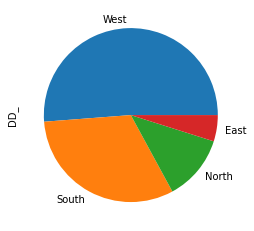

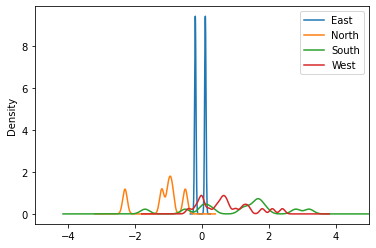

In [22]:
weatherC = AggData(df_merged, w_calm=False)
weatherC.all_data(min_diff=0, with_plot=True, with_kde = True, only_temp_below=-22, Nh=-1, Po=750)

,DD_,diff,abs_diff
0,East,-0.608401,0.894295
1,North,-0.594120,1.053935
2,South,0.493044,0.850911
3,West,0.542034,0.815480


<AxesSubplot:ylabel='DD_'>

rows:  7980


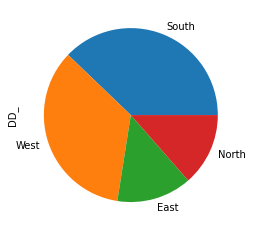

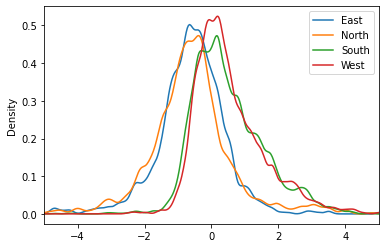

In [23]:
weatherC.all_data(min_diff=0, with_plot=True, with_kde = True, kde_abs_diff=False)

In [45]:
v2 = df_merged.groupby('DD', as_index=False)[['diff', 'abs_diff']].mean()
display(v2.rename(columns={'DD': 'Направление', 'diff': 'Разница'}))

,Направление,Разница,abs_diff
0,"Ветер, дующий с востока",-0.607995,0.899873
1,"Ветер, дующий с востоко-северо-востока",-0.651195,0.870307
2,"Ветер, дующий с востоко-юго-востока",-0.197990,0.720603
3,"Ветер, дующий с запада",0.531174,0.802834
4,"Ветер, дующий с западо-северо-запада",0.422727,0.930519
5,"Ветер, дующий с западо-юго-запада",0.588112,0.811189
6,"Ветер, дующий с севера",-0.915993,1.221717
7,"Ветер, дующий с северо-востока",-0.913656,1.067841
8,"Ветер, дующий с северо-запада",0.166182,0.830909
9,"Ветер, дующий с северо-северо-востока",-0.924510,1.144118


In [84]:
v2 = df_merged[df_merged['T'] <= -20].groupby('DD_', as_index=False)[['diff', 'abs_diff']].mean()
v2 = v2.replace({'Calm': 'Штиль', 'East': 'Восточный', 'North': 'Северный', 'South': 'Южный', 'West': 'Западный'})
display(v2.rename(columns={'DD_': 'Направление', 'diff': 'Разница'}))

,Направление,Разница,abs_diff
0,Штиль,-0.800000,1.586667
1,Восточный,-0.931579,1.117544
2,Северный,-1.041512,1.407560
3,Южный,0.866239,1.184771
4,Западный,0.999707,1.198534


In [131]:
v2 = df_merged[(df_merged['T'] <= -20)  & (df_merged['abs_diff'] >= 0.5) & (df_merged['Ff'] >= 5)].groupby('DD_', as_index=False)[['diff', 'abs_diff']].mean()
v2 = v2.replace({'Calm': 'Штиль', 'East': 'Восточный', 'North': 'Северный', 'South': 'Южный', 'West': 'Западный'})
display(v2.rename(columns={'DD_': 'Направление', 'diff': 'Разница'}))

,Направление,Разница,abs_diff
0,Восточный,-0.800000,0.920000
1,Северный,-0.957143,0.957143
2,Южный,0.422222,0.977778


In [147]:
len(df_merged[(df_merged['T'] <= -5)  & (df_merged['abs_diff'] >= 1) & (df_merged['Ff'] >= 0)].index)

2691

Text(0.5, 0, 'Разница температур')

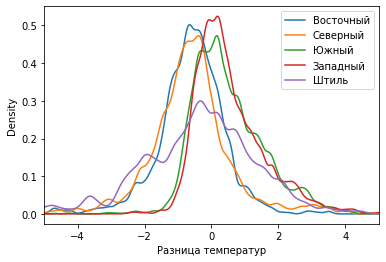

In [154]:
data = df_merged

fig, ax = plt.subplots()
data[(data['DD_'] == 'East')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'North')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'South')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'West')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'Calm')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
ax.legend(["Восточный", "Северный", "Южный", "Западный", "Штиль"])
plt.xlabel('Разница температур')

Text(0.5, 0, 'Разница температур')

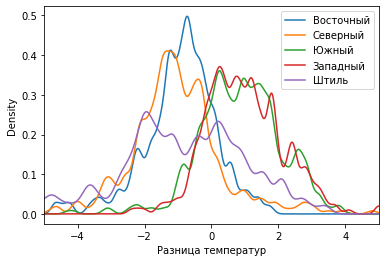

In [157]:
data = df_merged[df_merged['T'] <= -20]

fig, ax = plt.subplots()
data[(data['DD_'] == 'East')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'North')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'South')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'West')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'Calm')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
ax.legend(["Восточный", "Северный", "Южный", "Западный", "Штиль"])
plt.xlabel('Разница температур')

Text(0.5, 0, 'Разница температур')

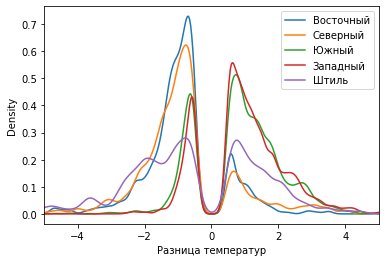

In [158]:
data = df_merged[df_merged['abs_diff'] >= 0.5]

fig, ax = plt.subplots()
data[(data['DD_'] == 'East')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'North')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'South')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'West')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
data[(data['DD_'] == 'Calm')]['diff'].plot.kde(bw_method=0.1, xlim=(-5,5))
ax.legend(["Восточный", "Северный", "Южный", "Западный", "Штиль"])
plt.xlabel('Разница температур')